# Using Machine Learning to Predict Fitbit Sleep Scores

In this project I'm going to apply various Machine Learning models to predict Fitbit Sleep Scores based on a sample of almost one year of sleep score data. I will compare the accuracies of teh different models and look into the feature importances in each of the models.

## Import the relevant libraries and data

In [72]:
# Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
# Import the data
sleep_data = pd.read_csv('combined.csv')

## Isolate the Fitbit App data

In [4]:
sleep_data.head()

,Unnamed: 0,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,0,2020-07-02,456,42,37,498,94,271,91,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,1,2020-07-01,412,88,32,500,79,208,125,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2,2020-06-30,412,61,26,473,91,242,79,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,3,2020-06-29,342,59,26,401,71,196,75,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,4,2020-06-28,530,108,39,638,98,305,127,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In [5]:
# Obtain the data available through the app
app_data = sleep_data[sleep_data.columns[2:10]]

In [6]:
app_data.head()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,456,42,37,498,94,271,91,86.0
1,412,88,32,500,79,208,125,77.0
2,412,61,26,473,91,242,79,78.0
3,342,59,26,401,71,196,75,76.0
4,530,108,39,638,98,305,127,82.0


In [7]:
# Obtain the subset of independent variables used for MLR previously
app_reduced = app_data.drop(columns=['Minutes Asleep', 'Number of Awakenings', 'Minutes Light Sleep'])

In [8]:
app_reduced.head()

,Minutes Awake,Time in Bed,Minutes REM Sleep,Minutes Deep Sleep,overall_score
0,42,498,94,91,86.0
1,88,500,79,125,77.0
2,61,473,91,79,78.0
3,59,401,71,75,76.0
4,108,638,98,127,82.0


## Split the data into training and test set

In [11]:
# Perform split
X_train, X_test, y_train, y_test = train_test_split(app_reduced[app_reduced.columns[:-1]], app_reduced['overall_score'],
                                                   random_state=420)

## Scaling the features

Although for the Machine Learning Models in this project feature scaling is not required, it is considered best practice to scale features when comparing different models and their performance.

In [18]:
# Create the scaler with object range of 0-1
scaler = MinMaxScaler()

# Fit and transform using the training data
scaler.fit_transform(X_train)

# Transform the test features
scaler.transform(X_test)

array([[0.23076923, 0.54659498, 0.53939394, 0.53900709],
       [0.44444444, 0.47849462, 0.40606061, 0.53900709],
       [0.4017094 , 0.63799283, 0.53939394, 0.68085106],
       [0.43589744, 0.68996416, 0.70909091, 0.64539007],
       [0.30769231, 0.57526882, 0.68484848, 0.75886525],
       [0.58974359, 0.84767025, 0.51515152, 0.68794326],
       [0.33333333, 0.35483871, 0.23636364, 0.39007092],
       [0.51282051, 0.71505376, 0.6969697 , 0.53900709],
       [0.35897436, 0.44623656, 0.28484848, 0.73049645],
       [0.37606838, 0.58243728, 0.27272727, 0.45390071],
       [0.41025641, 0.5125448 , 0.54545455, 0.68085106],
       [0.45299145, 0.69713262, 0.51515152, 0.64539007],
       [0.52136752, 0.4265233 , 0.        , 0.44680851],
       [0.51282051, 0.70430108, 0.57575758, 0.5106383 ],
       [0.31623932, 0.5125448 , 0.56969697, 0.41134752],
       [0.47863248, 0.52150538, 0.43030303, 0.53900709],
       [0.84615385, 1.        , 0.64848485, 0.77304965],
       [0.33333333, 0.32437276,

## Defining performance measures

The performance measures I want to use to compare the different ML models are Accuracy and Score. Average Error is added to the list as an extra.

In [56]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

## Multiple Linear Regression

The first model I would like to use is MLR. I used MLR in another project to understand the relationship between the independent variables and the sleep score. This time, I will use it to make predictions about sleep scores and test the accuracy of this linear model.

In [20]:
# Create regressor
regressor = LinearRegression()

# Fit MLR model to training data
mlr = regressor.fit(X_train, y_train)

In [57]:
# Evaluate the performance
scoring(mlr, X_test, y_test)

Model Performance
Mean Absolute Error: 2.3757.
Mean Squared Error: 8.7633.
R^2 Score = 0.7165.
Accuracy = 97.06%.


Let's have a look at the feature importances in the Regression. To compute them I will use the relative weight of the coefficients.

In [29]:
# Get coefficients
coef = mlr.coef_

In [39]:
# Create a DataFrame with the coefficients and feature importances of all independent variables
mlr_feats = pd.DataFrame()

# Create coeffciient column
mlr_feats['Coefficient'] = coef

# Set the index to teh corresponding independent variables
mlr_feats.index = X_train.columns

# Compute relative feature importances
mlr_feats['Relative Feature Importance'] = mlr_feats.apply(lambda x: abs(x)/mlr_feats.Coefficient.abs().sum())
mlr_feats

,Coefficient,Relative Feature Importance
Minutes Awake,-0.163098,0.509441
Time in Bed,0.048444,0.151317
Minutes REM Sleep,0.069580,0.217336
Minutes Deep Sleep,0.039028,0.121906


The coefficients in our model are close to those of the MLR using the entire dataset. Looking at the feature importances in combination with the sign of the coefficients provides an important insight (ignoring multicollinearity!). Minutes Awake seem to have the biggest impact on sleep score and because that variable has a negative coefficient, it's impact is a sleep score reducing one. Disregarding multicollinearity, these feature importances indicate that it takes more than two minutes of REM sleep to make up for one minute of being awake. Furthermore, REM sleep appears to be almost twice as important as deep sleep when it comes to their impact on sleep score.

## K-Nearest Neighbors

In [73]:
# Create regressor
knn_regressor = KNeighborsRegressor()

# Fit MLR model to training data
knn = knn_regressor.fit(X_train, y_train)

In [74]:
# Evaluate the performance
scoring(knn, X_test, y_test)

Model Performance
Mean Absolute Error: 2.4000.
Mean Squared Error: 8.8344.
R^2 Score = 0.7142.
Accuracy = 97.03%.


## Random Forest

In [26]:
# Create regressor
rf_regressor = RandomForestRegressor(n_estimators=500, random_state=420)

# Fit RF model to training data
rf = rf_regressor.fit(X_train, y_train)

In [58]:
# Evaluate the performance
scoring(rf, X_test, y_test)

Model Performance
Mean Absolute Error: 2.1169.
Mean Squared Error: 7.9669.
R^2 Score = 0.7423.
Accuracy = 97.38%.


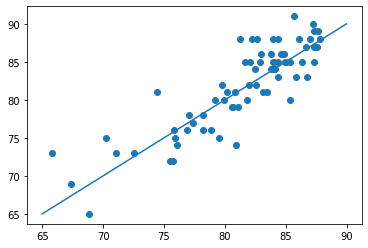

In [45]:
# Make predictions
y_pred = rf.predict(X_test)

x = np.linspace(65, 90, 25)
y = x

plt.scatter(y_pred, y_test)
plt.plot(x, y)

In [70]:
# Create a DataFrame of the feature importances 
rf_feats = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
rf_feats

,Feature Importance
Minutes Awake,0.110282
Time in Bed,0.191161
Minutes REM Sleep,0.601761
Minutes Deep Sleep,0.096797


In case of a random forest regression, feature importance represents a measure of how much a feature decreases impurity in the set decision trees. Remember that at every node in a tree the data has to be split so that similar value sof dependent variables end up in the same set after the split, thereby decreasing the impurity. For classification problems, the measure of impurity is called Gini Impurity, which is absed on information gain, and for regression problems the measure of impurity is variance. In a random forest regression, therefore, a more important feature is one that leads to a split in the dataset that leads to a strong decrease in variance.

Minutes REM sleep appears to be the feature that decreases impurity the most, followed by Time in Bed and then Minutes Awake and Minutes Deep Sleep. 

In this model, we have to be careful and not attach too much value to the feature importances of the model. The reason is that the features are correlated and therefore once one of the features is used as a predictor the importance of the others will automatically be reduced since a lot of the impurity that they could have removed is already removed by the feature that was considered before them and is highly correlated to them.

Next, let's look at Extreme Gradient Boosting.

## Extreme Gradient Boosting 

In [61]:
# Create regressor
xgb_regressor = XGBRegressor()

# Fit model to training data
xgb = xgb_regressor.fit(X_train, y_train)

In [62]:
# Evaluate the performance
scoring(xgb, X_test, y_test)

Model Performance
Mean Absolute Error: 2.2560.
Mean Squared Error: 8.6542.
R^2 Score = 0.7201.
Accuracy = 97.19%.


In [63]:
xgb.feature_importances_

array([0.13239308, 0.2177284 , 0.48529273, 0.1645858 ], dtype=float32)

In [69]:
# Create a DataFrame to inspect the feature importances again
xgb_feats = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['Feature Importance'])
xgb_feats

,Feature Importance
Minutes Awake,0.132393
Time in Bed,0.217728
Minutes REM Sleep,0.485293
Minutes Deep Sleep,0.164586


Interestingly, Minutes REM Sleep is by far the most important feature again and, similar to the Random Forest, Time in Bed is the second most important.